In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Question: Is there overlap in popularity between TikTok and Spotify?

# Loading and Cleaning the Data


In [ ]:
df = pd.read_csv('spot_streams_cleaned.csv')
print(df.columns
    )

features = [
    'Spotify Streams', 'Spotify Playlist Count', 'Spotify Playlist Reach', 'Spotify Popularity',
    'TikTok Posts', 'TikTok Likes', 'TikTok Views'
]

# Clean numeric strings with commas and convert to float
for col in features:
    df[col] = df[col].astype(str).str.replace(',', '', regex=False)
    df[col] = pd.to_numeric(df[col], errors='coerce')


# Drops unknown values!
data = df[features].dropna()



Index(['Track', 'Album Name', 'Artist', 'Release Date', 'ISRC',
       'All Time Rank', 'Track Score', 'Spotify Streams',
       'Spotify Playlist Count', 'Spotify Playlist Reach',
       'Spotify Popularity', 'YouTube Views', 'YouTube Likes', 'TikTok Posts',
       'TikTok Likes', 'TikTok Views', 'YouTube Playlist Reach',
       'Apple Music Playlist Count', 'AirPlay Spins', 'SiriusXM Spins',
       'Deezer Playlist Count', 'Deezer Playlist Reach',
       'Amazon Playlist Count', 'Pandora Streams', 'Pandora Track Stations',
       'Soundcloud Streams', 'Shazam Counts', 'TIDAL Popularity',
       'Explicit Track'],
      dtype='object')


# K-Clustering Model


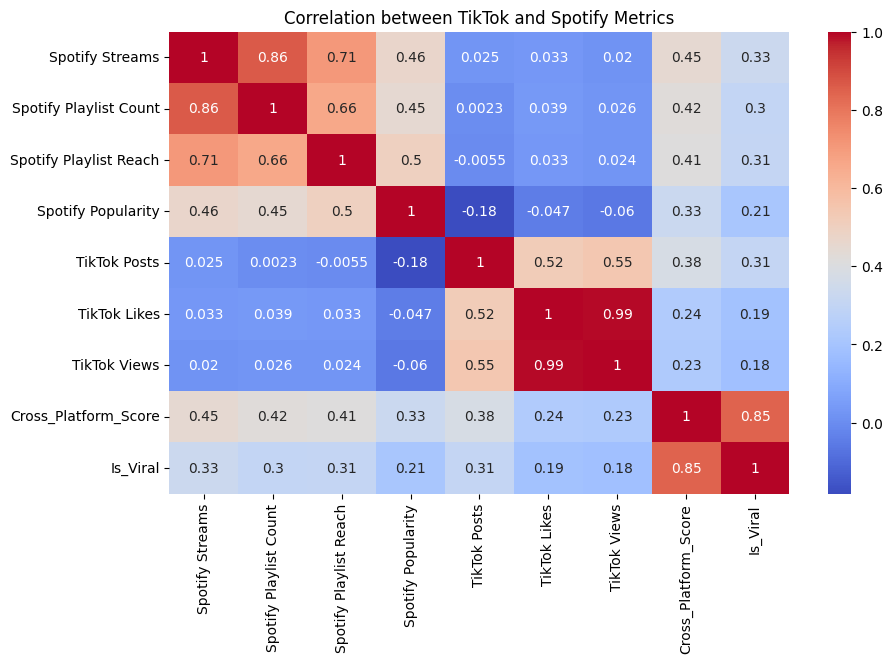

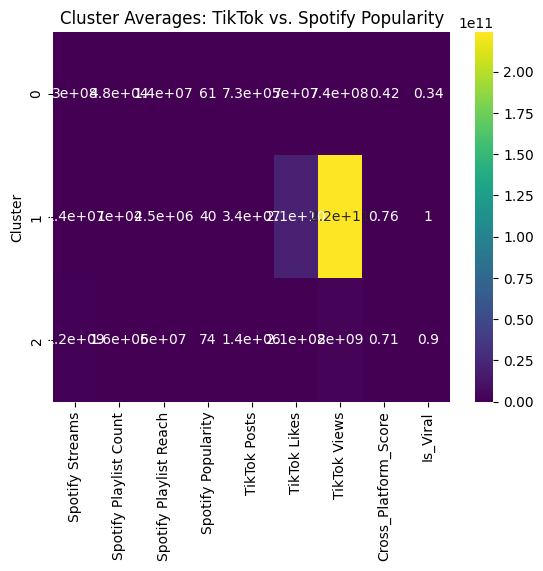

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation between TikTok and Spotify Metrics')
plt.show()

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

kmeans = KMeans(n_clusters=3, random_state=42)
data['Cluster'] = kmeans.fit_predict(scaled_data)

cluster_means = data.groupby('Cluster').mean()
sns.heatmap(cluster_means, annot=True, cmap='viridis')
plt.title('Cluster Averages: TikTok vs. Spotify Popularity')
plt.show()

# Gaussian Naive Bayes Model

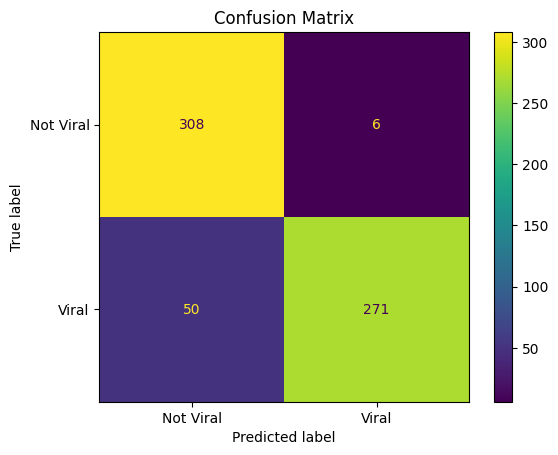

Precision: 0.98
Recall: 0.84
F1-Score: 0.91


In [ ]:
# Create composite score (normalized weights)
data['Cross_Platform_Score'] = (
    0.25 * data['Spotify Popularity'].rank(pct=True) +
    0.25 * data['TikTok Likes'].rank(pct=True) +
    0.25 * data['TikTok Views'].rank(pct=True) +
    0.25 * data['TikTok Posts'].rank(pct=True)
)

# Binarize target
data['Is_Viral'] = (data['Cross_Platform_Score'] > data['Cross_Platform_Score'].median()).astype(int)

# Features (all except target and raw streams)
X = data.drop(['Spotify Streams', 'Is_Viral'], axis=1)
y = data['Is_Viral'] # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train GNB
model = GaussianNB()
model.fit(X_train_scaled, y_train)

# Confusion Matrix
y_pred = model.predict(X_test_scaled)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['Not Viral', 'Viral'])
plt.title("Confusion Matrix")
plt.show()

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Non-Linear SVM


In [ ]:
is_spotify_popular = (df['Spotify Popularity'] >= 70).astype(int)
tiktok_features = df[['TikTok Posts', 'TikTok Likes', 'TikTok Views']]

tiktok_features = tiktok_features.dropna()
is_spotify_popular = is_spotify_popular[tiktok_features.index]


X_train, X_test, y_train, y_test = train_test_split(
    tiktok_features, is_spotify_popular, test_size=0.2, random_state=42
)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm_classifier = SVC(kernel='rbf', C=1, gamma='scale', class_weight = 'balanced')
svm_classifier.fit(X_train_scaled, y_train)


predictions = svm_classifier.predict(X_test_scaled)
print(classification_report(y_test, predictions, zero_division = 0))

              precision    recall  f1-score   support

           0       0.69      0.77      0.73       442
           1       0.45      0.35      0.39       239

    accuracy                           0.62       681
   macro avg       0.57      0.56      0.56       681
weighted avg       0.60      0.62      0.61       681



In [ ]:
is_spotify_popular = (df['Spotify Popularity'] >= 60).astype(int)
tiktok_features = df[['TikTok Posts', 'TikTok Likes', 'TikTok Views']]

tiktok_features = tiktok_features.dropna()
is_spotify_popular = is_spotify_popular[tiktok_features.index]


X_train, X_test, y_train, y_test = train_test_split(
    tiktok_features, is_spotify_popular, test_size=0.2, random_state=42
)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm_classifier = SVC(kernel='rbf', C=1, gamma='scale',class_weight = 'balanced')
svm_classifier.fit(X_train_scaled, y_train)


predictions = svm_classifier.predict(X_test_scaled)
print(classification_report(y_test, predictions, zero_division = 0))

              precision    recall  f1-score   support

           0       0.45      0.31      0.37       160
           1       0.81      0.88      0.84       521

    accuracy                           0.75       681
   macro avg       0.63      0.60      0.60       681
weighted avg       0.72      0.75      0.73       681

